In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
from scipy import signal

import IPython.display
import cmocean as cm
import sys, os, glob
import warnings
warnings.simplefilter("ignore") 

from IPython.display import Image

from dask.distributed import Client

from matplotlib.patches import Rectangle

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['font.size'] = 15
letlab = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)',
          '(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)',
          '(q)','(r)','(s)','(t)','(u)','(v)','(w)','(x)','(y)','(z)']

In [3]:
# Load workers:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:45621' processes=8 threads=8, memory=22.46 GiB>

## Load datasets

In [4]:
base = '/g/data/e14/rmh561/croco/'
base_data = base + 'archive/'
base_analysis = base + '/analysis/'

os.chdir(base_analysis + 'PAC12_75_cpl')

In [5]:
# define runs:
expdict = {
           'CROCO-WRF Control':{'exp':'PAC12_75_cpl','expn':'exp02','CPL':True}
#          ,'CROCO-WRF Spinup':{'exp':'PAC12_75_cpl','expn':'exp01','CPL':True}
          ,'CROCO-WRF Smooth-SST':{'exp':'PAC12_75_cpl','expn':'exp03','CPL':True}
#          ,'CROCO-WRF Smooth-SST-E2':{'exp':'PAC12_75_cpl','expn':'exp04','CPL':True}
          ,'CROCO-WRF NoCFB':{'exp':'PAC12_75_cpl','expn':'exp06','CPL':True}
          ,'CROCO-WRF NoMesoCFB':{'exp':'PAC12_75_cpl','expn':'exp07','CPL':True}
#          ,'CROCO Control':{'exp':'PAC12_75','expn':'exp11','CPL':False}
#          ,'CROCO PP81':{'exp':'PAC12_75','expn':'exp12','CPL': False}
          }
cont = 'CROCO-WRF Control'

In [6]:
# Load CROCO data:
data_typs = ['mon','3day','day','ts_3day']
dropyears = ['2016','2017','2018']

data = {}
for nam in expdict.keys():
    print(nam)
    exp = expdict[nam]['exp']
    expn = expdict[nam]['expn']
    data[nam] = {}
    for typ in data_typs:
        try:
            files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_' + typ + '.nc'))
            for yr in dropyears:
                files = [file for file in files if yr not in file]
            data[nam][typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
        except:
            data[nam][typ] = None
gfiles = glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_grd.nc')
grd = xr.open_dataset(gfiles[0],chunks={'y_rho':100,'x_rho':100})

CROCO-WRF Control
CROCO-WRF Smooth-SST
CROCO-WRF NoCFB
CROCO-WRF NoMesoCFB


In [ ]:
# Deal with CROCO coordinates:
for nam in expdict.keys():
    print(nam)
    for d in data[nam].values():
        if d is not None:
            try:
                d["x_rho"] = d.nav_lon_rho.isel(y_rho=0)
                d["y_rho"] = d.nav_lat_rho.isel(x_rho=0)
                d["x_w"] = d.nav_lon_rho.isel(y_rho=0).rename({'x_rho':'x_w'})
                d["y_w"] = d.nav_lat_rho.isel(x_rho=0).rename({'y_rho':'y_w'})
                d["x_u"] = d.nav_lon_u.isel(y_u=0)
                d["y_u"] = d.nav_lat_u.isel(x_u=0)
                d["x_v"] = d.nav_lon_v.isel(y_v=0)
                d["y_v"] = d.nav_lat_v.isel(x_v=0)
                d = d.set_coords({'x_rho','y_rho','x_u','y_u','x_v','y_v','x_w','y_w'})
                
            except:
                d["x_rho"] = d.nav_lon.isel(y=0)
                d["y_rho"] = d.nav_lat.isel(x=0)
                d = d.set_coords({'x_rho','y_rho'})
                
            try:
                d["z_rho"] = d.z_rho.mean('time').fillna(0.)
                d = d.set_coords({'z_rho'})
                
            except:
                pass

# Generate xgcm grid object:
grid = Grid(data[nam]['mon'],coords={"x":{"center":"x_rho","inner":"x_u"},
                         "y":{"center":"y_rho","inner":"y_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

CROCO-WRF Control
CROCO-WRF Smooth-SST


In [ ]:
# Load WRF data:
data_typs = {'day':'3d_1D','hr':'3d_1H','mon':'out'}

for nam in expdict.keys():
    if expdict[nam]['CPL']:
        print(nam)
        exp = expdict[nam]['exp']
        expn = expdict[nam]['expn']
        for typ in data_typs.keys():
            try:
                files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/wrf' + data_typs[typ] + '*.nc'))
                for yr in dropyears:
                    files = [file for file in files if yr not in file]
                data[nam]['wrf_' + typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
            except:
                data[nam]['wrf_' + typ] = None
        if data[nam]['wrf_day'] is not None:
            lon = data[nam]['wrf_day'].nav_lon.isel(y=0)
            lon = np.where(np.less(lon,0.).values,lon+360.,lon)
            lat = data[nam]['wrf_day'].nav_lat.isel(x=0).values
            for typ in data_typs:
                if data[nam]['wrf_' + typ] is not None:
                    data[nam]['wrf_' + typ]["x"] = lon
                    data[nam]['wrf_' + typ]["y"] = lat

In [ ]:
# Set limit parameters for observations:
for nam in expdict.keys():
    try:
        minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
        maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
        print(nam + ' minyr=' + str(minyr) + ' maxyr=' + str(maxyr))
    except:
        print('No data for ' + nam)
nam = 'CROCO-WRF Control'
minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
minlon = data[nam]['mon'].x_rho.min('x_rho').values
maxlon = data[nam]['mon'].x_rho.max('x_rho').values
minlat = data[nam]['mon'].y_rho.min('y_rho').values
maxlat = data[nam]['mon'].y_rho.max('y_rho').values

In [ ]:
# # Limit simulations to same years:
# data_typs = ['mon','3day','day','ts_3day']
# for nam in expdict.keys():
#     for typ in data_typs:
#         try:
#             data[nam][typ] = data[nam][typ].sel(time=slice(str(minyr) + '-01-01',str(maxyr) + '-12-31'))
#         except:
#             pass
        
# data_typs = {'day':'3d_1D','hr':'3d_1H','mon':'out'}
# for nam in expdict.keys():
#     if expdict[nam]['CPL']:
#         for typ in data_typs.keys():
#             try:
#                 data[nam]['wrf_' + typ] = data[nam]['wrf_' + typ].sel(time=slice(str(minyr) + '-01-01',str(maxyr) + '-12-31'))
#             except:
#                 pass     

In [ ]:
# Observational SST:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*_' + str(yr) + '.nc'))
OISST = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True).isel(zlev=0)

OISST = OISST.sel(lon=slice(minlon,maxlon)).sel(lat=slice(minlat,maxlat))
OISST = OISST.rename({'lon':'x_rho','lat':'y_rho'})

In [ ]:
# Observational SSH:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/ua8/CMEMS_SeaLevel/v2019/' + str(yr) + '/*.nc'))
CMEMS = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

CMEMS = CMEMS.sel(longitude=slice(minlon,maxlon)).sel(latitude=slice(minlat,maxlat))
CMEMS = CMEMS.rename({'longitude':'x_rho','latitude':'y_rho'})

In [ ]:
# SODA reanalysis:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/e14/rmh561/croco/data/DATA/SODA342_PAC12_75/soda3.4.2_5dy_ocean_reg_' + str(yr) + '_*.nc'))
SODA = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

SODA = SODA.sel(xt_ocean=slice(minlon,maxlon)).sel(yt_ocean=slice(minlat,maxlat)).sel(xu_ocean=slice(minlon,maxlon)).sel(yu_ocean=slice(minlat,maxlat))
SODA = SODA.rename({'xt_ocean':'x_rho','yt_ocean':'y_rho'})

In [ ]:
# ACCESS-OM2 data:
import cosima_cookbook as cc
session = cc.database.create_session()
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degIAF',   {'model':'ACCESS-OM2 IAF', 'expt':'1deg_jra55_iaf_omip2_cycle6', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
    ('025degIAF', {'model':'ACCESS-OM2-025 IAF', 'expt':'025deg_jra55_iaf_omip2_cycle6', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
    ('01degIAF', {'model':'ACCESS-OM2-01 IAF', 'expt':'01deg_jra55v140_iaf_cycle3', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
])

# Domain Schematic:

In [ ]:
time = '2016-11-01'
plt.figure(figsize=(10,5))

# EPAC only:
xlims = [115.,300.]
ylims = [-35.,35.]
vlims = [18.,30.]

# EPAC and BPAC:
xlims = [100.,300.]
ylims = [-35.,35.]
vlims = [18.,30.]

ps = OISST.sst.sel(x_rho=slice(xlims[0],xlims[1])).sel(y_rho=slice(ylims[0],ylims[1])).sel(time=time).plot(cmap=cm.cm.thermal,vmin=vlims[0],vmax=vlims[1],cbar_kwargs={'label':''})

data['CROCO-WRF Control']['day'].temp_surf.sel(time=time).plot(cmap=cm.cm.thermal,vmin=vlims[0],vmax=vlims[1],add_colorbar=False)
#data['wrf_day'].WSPD10.sel(time=time).isel(time=0).plot.contour(levels=np.arange(0.,25.,2.),colors='k')
plt.gca().set_facecolor('k')
plt.gca().set_xlim(xlims)
plt.gca().set_ylim(ylims)
plt.gca().add_patch(Rectangle((minlon, minlat), maxlon-minlon, maxlat-minlat,
             edgecolor = 'green',
             fill=False,
             lw=1))
plt.gca().text(minlon+1.,minlat+1.,'EPAC',color='green',fontsize=20)

# BPAC:
BPACminlon = 110.
BPACmaxlon = 290.
BPACminlat = -30.
BPACmaxlat = 30.
plt.gca().add_patch(Rectangle((BPACminlon, BPACminlat), BPACmaxlon-BPACminlon, BPACmaxlat-BPACminlat,
             edgecolor = 'green',
             fill=False,
             lw=1))
plt.gca().text(BPACminlon+1.,BPACminlat+1.,'BPAC',color='green',fontsize=20)

N34minlon = 190.
N34maxlon = 240.
N34minlat = -5.
N34maxlat = 5.
plt.gca().add_patch(Rectangle((N34minlon, N34minlat), N34maxlon-N34minlon, N34maxlat-N34minlat,
             edgecolor = 'black',
             linestyle = 'dashed',
             fill=False,
             lw=1))
plt.gca().text(BPACminlon+1.,BPACminlat+1.,'BPAC',color='green',fontsize=20)

plt.title('OISST and CROCO-WRF SST ' + time + ' ($^\circ$C)',fontsize=15)
plt.xlabel('Longitude ($^\circ$E)',fontsize=15)
plt.ylabel('Latitude ($^\circ$N)',fontsize=15)
for item in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(15)
plt.tight_layout()

plt.savefig('Domain_Fig.png',dpi=250)

# CROCO-WRF Control and Smooth-SST SST and surface heat fluxes (snapshots, short periods):

In [ ]:
#Calculations:
time = '2016-11-01'
tlims = [20.,29.]

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10),facecolor='w')
(data['CROCO-WRF Control']['wrf_day'].SST-273.15).sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1])
axes[0][0].set_title('CROCO-WRF Spinup WRF SST ' + time)
(data['CROCO-WRF Smooth-SST']['wrf_day'].SST-273.15).sel(time=time).plot(ax=axes[0][1],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1])
axes[0][1].set_title('CROCO-WRF Smooth-SST WRF SST ' + time)
# Add Gaussian smoother plot:
x = data['CROCO-WRF Smooth-SST']['wrf_day'].SST.x
gausy = 5.*np.exp(-.5*(x-240.)**2./(24.*1./4.)**2.)
axes[0][1].plot(x,gausy,'--k')
axes[0][0].plot(x,gausy,'--k')

data['CROCO-WRF Control']['day'].temp_surf.sel(time=time).plot(ax=axes[1][0],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1])
axes[1][0].set_title('CROCO-WRF Spinup CROCO SST ' + time)
data['CROCO-WRF Smooth-SST']['day'].temp_surf.sel(time=time).plot(ax=axes[1][1],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1])
axes[1][1].set_title('CROCO-WRF Smooth-SST CROCO SST ' + time)
plt.tight_layout()

plt.savefig('Smooth-SST/SST_Example_2016-11.png',dpi=100)

In [ ]:
#Calculations:
time = '2016-11-01'

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10),facecolor='w')
data['CROCO-WRF Control']['wrf_day'].VOCE.sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[0][0].set_title('CROCO-WRF Spinup WRF V ' + time)
data['CROCO-WRF Smooth-SST']['wrf_day'].VOCE.sel(time=time).plot(ax=axes[0][1],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[0][1].set_title('CROCO-WRF Smooth-SST WRF V ' + time)
data['CROCO-WRF Control']['day'].v_surf.sel(time=time).plot(ax=axes[1][0],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[1][0].set_title('CROCO-WRF Spinup CROCO V ' + time)
data['CROCO-WRF Smooth-SST']['day'].v_surf.sel(time=time).plot(ax=axes[1][1],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[1][1].set_title('CROCO-WRF Smooth-SST CROCO V ' + time)

plt.tight_layout()

plt.savefig('Smooth-SST/V_Example_2016-11.png',dpi=100)

In [ ]:
# Flux Calculations:
times = ['2016-11-01','2016-11-01']
#times = ['2016-11-01','2016-11-12']

fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(30,25),facecolor='w')

# CROCO-only SST snapshots for sensible heat flux:
SST = data['CROCO Control']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time')
OBS_SST = OISST.sst.sel(time=slice(times[0],times[1])).mean('time')

# Total heat flux:
data['CROCO-WRF Control']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][0],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[0][0].set_title('CROCO-WRF Control CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])
data['CROCO-WRF Smooth-SST']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][1],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[0][1].set_title('CROCO-WRF Smooth-SST CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][2],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[0][2].set_title('CROCO Control CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])

# Sensible heat flux:
SHFLX = -data['CROCO-WRF Control']['wrf_day'].HFX
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][0],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[1][0].set_title('CROCO-WRF Control WRF Sensible HF ' + times[0] + ' ' + times[1])
SHFLX = -data['CROCO-WRF Smooth-SST']['wrf_day'].HFX
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][1],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[1][1].set_title('CROCO-WRF Smooth-SST WRF Sensible HF ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx_sen.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][2],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[1][2].set_title('CROCO Control CROCO Sensible HF ' + times[0] + ' ' + times[1])

SST.plot.contour(ax=axes[1][2],levels=[25.],colors='k')
OBS_SST.plot.contour(ax=axes[1][2],levels=[25.],colors='k',linestyles='dashed')

# Latent heat flux:
SHFLX = -data['CROCO-WRF Control']['wrf_day'].LH
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[2][0],cmap='RdBu_r',vmin=-200.,vmax=200.)
axes[2][0].set_title('CROCO-WRF Control WRF Latent HF ' + times[0] + ' ' + times[1])
SHFLX = -data['CROCO-WRF Smooth-SST']['wrf_day'].LH
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[2][1],cmap='RdBu_r',vmin=-200.,vmax=200.)
axes[2][1].set_title('CROCO-WRF Smooth-SST WRF Latent HF ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx_lat.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[2][2],cmap='RdBu_r',vmin=-200.,vmax=200.)
axes[2][2].set_title('CROCO Control CROCO Latent HF ' + times[0] + ' ' + times[1])

# Shortwave heat flux:
data['CROCO-WRF Control']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[3][0],cmap='RdBu_r',vmin=-350.,vmax=350.)
axes[3][0].set_title('CROCO-WRF Control CROCO SW Radiation ' + times[0] + ' ' + times[1])
data['CROCO-WRF Smooth-SST']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[3][1],cmap='RdBu_r',vmin=-350.,vmax=350.)
axes[3][1].set_title('CROCO-WRF Smooth-SST CROCO SW Radiation ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].radsw.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[3][2],cmap='RdBu_r',vmin=-350.,vmax=350.)
axes[3][2].set_title('CROCO Control CROCO SW Radiation ' + times[0] + ' ' + times[1])

# Downward longwave heat flux:
SHFLX = -data['CROCO-WRF Control']['wrf_day'].GLW
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[4][0],cmap='RdBu_r',vmin=-500.,vmax=500.)
axes[4][0].set_title('CROCO-WRF Control WRF Downward Longwave HF ' + times[0] + ' ' + times[1])
SHFLX = -data['CROCO-WRF Smooth-SST']['wrf_day'].GLW
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[4][1],cmap='RdBu_r',vmin=-500.,vmax=500.)
axes[4][1].set_title('CROCO-WRF Smooth-SST WRF Downward Longwave HF ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx_rlw.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[4][2],cmap='RdBu_r',vmin=-100.,vmax=100.)
axes[4][2].set_title('CROCO Control CROCO NET Longwave HF ' + times[0] + ' ' + times[1])

plt.tight_layout()

plt.savefig('Smooth-SST/Surface_Fluxes_Example_2016-11-01.png',dpi=100)
#plt.savefig('Smooth-SST/Surface_Fluxes_Example_2016-11-01_to_2016-11-12.png',dpi=100)

In [ ]:
# Flux Calculations:
times = ['2016-11-01','2016-11-01']
times = ['2016-11-01','2016-11-30']

fig,axes = plt.subplots(nrows=5,ncols=1,figsize=(10,25),facecolor='w')

axs = axes.reshape(-1)

# Total heat flux:
(data['CROCO-WRF Smooth-SST']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time')-data['CROCO-WRF Control']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time')).plot(ax=axes[0],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[0].set_title('CROCO-WRF Control CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])

# Sensible heat flux:
SHFLX1 = -data['CROCO-WRF Control']['wrf_day'].HFX.sel(time=slice(times[0],times[1])).mean('time')
SHFLX2 = -data['CROCO-WRF Smooth-SST']['wrf_day'].HFX.sel(time=slice(times[0],times[1])).mean('time')
(SHFLX2-SHFLX1).plot(ax=axes[1],cmap='RdBu_r',vmin=-20.,vmax=20.)
axes[1].set_title('CROCO-WRF Control WRF Sensible HF ' + times[0] + ' ' + times[1])

# Latent heat flux:
SHFLX1 = -data['CROCO-WRF Control']['wrf_day'].LH.sel(time=slice(times[0],times[1])).mean('time')
SHFLX2 = -data['CROCO-WRF Smooth-SST']['wrf_day'].LH.sel(time=slice(times[0],times[1])).mean('time')
(SHFLX2-SHFLX1).plot(ax=axes[2],cmap='RdBu_r',vmin=-20.,vmax=20.)
axes[2].set_title('CROCO-WRF Control WRF Latent HF ' + times[0] + ' ' + times[1])

# Shortwave heat flux:
(data['CROCO-WRF Smooth-SST']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time')-data['CROCO-WRF Control']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time')).plot(ax=axes[3],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[3].set_title('CROCO-WRF Control CROCO SW Radiation ' + times[0] + ' ' + times[1])

# Downward longwave heat flux:
SHFLX1 = -data['CROCO-WRF Control']['wrf_day'].GLW.sel(time=slice(times[0],times[1])).mean('time')
SHFLX2 = -data['CROCO-WRF Smooth-SST']['wrf_day'].GLW.sel(time=slice(times[0],times[1])).mean('time')
(SHFLX2-SHFLX1).plot(ax=axes[4],cmap='RdBu_r',vmin=-20.,vmax=20.)
axes[4].set_title('CROCO-WRF Control WRF Downward Longwave HF ' + times[0] + ' ' + times[1])

plt.tight_layout()

plt.savefig('Smooth-SST/Surface_Fluxes_Example_2016-11-01_to_2016-11-31_Difference.png',dpi=100)

# Mean state differences:

In [10]:
# Calculations
SST = {}
SSH = {}
SSS = {}
SWFLX = {}
TAUU = {}
TAUV = {}

keys = ['CROCO-WRF Control','CROCO-WRF Smooth-SST-E2']
for key in keys:
    print(key)
    SST[key] = data[key]['mon'].temp.isel(s_rho=-1).mean('time')
    SSH[key] = data[key]['mon'].zeta.mean('time') - data[key]['mon'].zeta.mean('time').mean('x_rho').mean('y_rho')
    SSS[key] = data[key]['mon'].salt.isel(s_rho=-1).mean('time')
    SWFLX[key] = data[key]['mon'].swflx.mean('time').load()
    TAUU[key] = data[key]['mon'].sustr.mean('time').load()
    TAUV[key] = data[key]['mon'].svstr.mean('time').load()

CROCO-WRF Control
CROCO-WRF Smooth-SST-E2


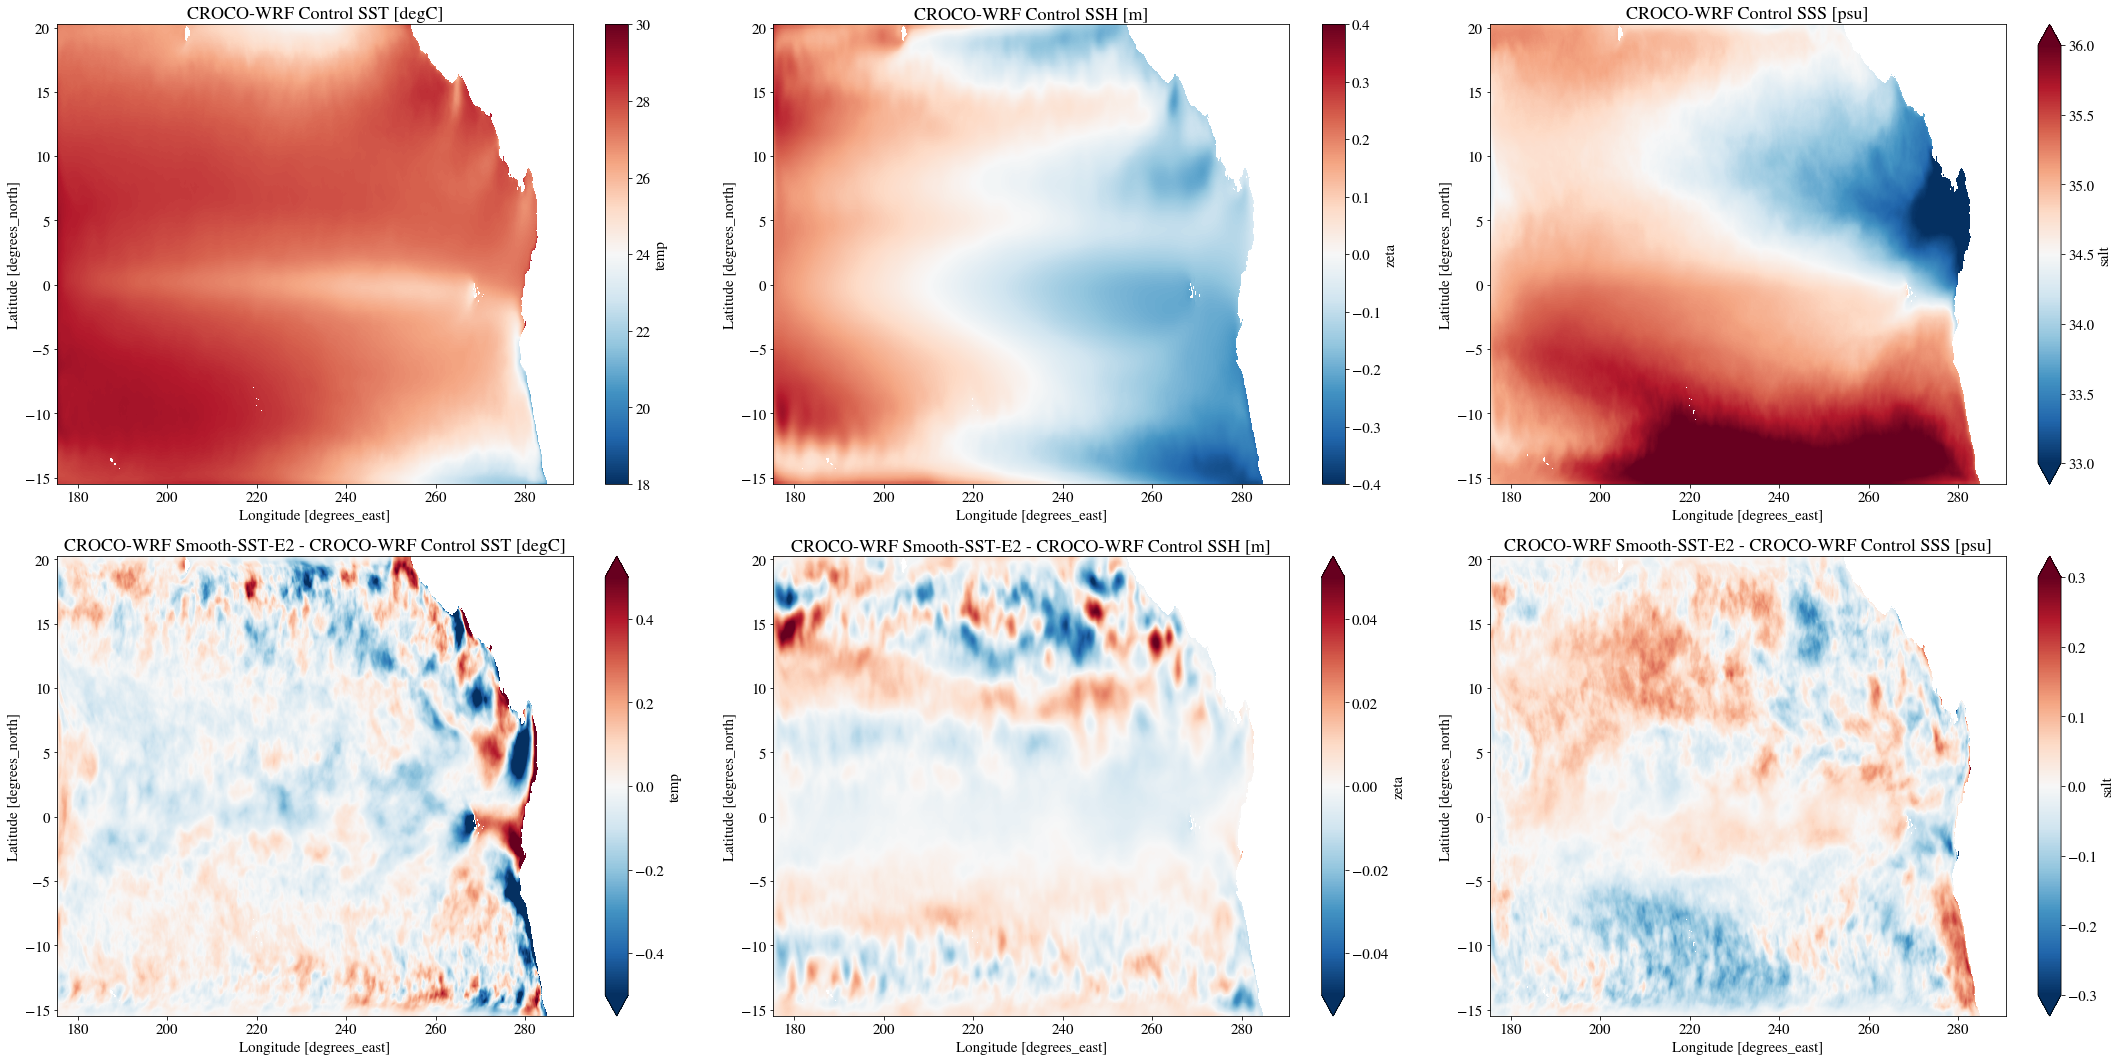

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(30,15),facecolor='w')

SST[cont].plot(ax=axes[0][0],vmin=18.,vmax=30.,cmap='RdBu_r')
axes[0][0].set_title(cont + ' SST [degC]')
SSH[cont].plot(ax=axes[0][1],vmin=-0.4,vmax=0.4,cmap='RdBu_r')
axes[0][1].set_title(cont + ' SSH [m]')
SSS[cont].plot(ax=axes[0][2],vmin=33.,vmax=36.,cmap='RdBu_r')
axes[0][2].set_title(cont + ' SSS [psu]')

(SST[key]-SST[cont]).plot(ax=axes[1][0],vmin=-0.5,vmax=0.5,cmap='RdBu_r')
axes[1][0].set_title(key + ' - ' + cont + ' SST [degC]')
(SSH[key]-SSH[cont]).plot(ax=axes[1][1],vmin=-0.05,vmax=0.05,cmap='RdBu_r')
axes[1][1].set_title(key + ' - ' + cont + ' SSH [m]')
(SSS[key]-SSS[cont]).plot(ax=axes[1][2],vmin=-0.3,vmax=0.3,cmap='RdBu_r')
axes[1][2].set_title(key + ' - ' + cont + ' SSS [psu]')

plt.tight_layout()
plt.savefig('CROCO-WRF_Smooth_SST-E2_2015-2016_SurfaceAnomalies.png',dpi=100)

KeyError: 'CROCO-WRF Smooth-SST'

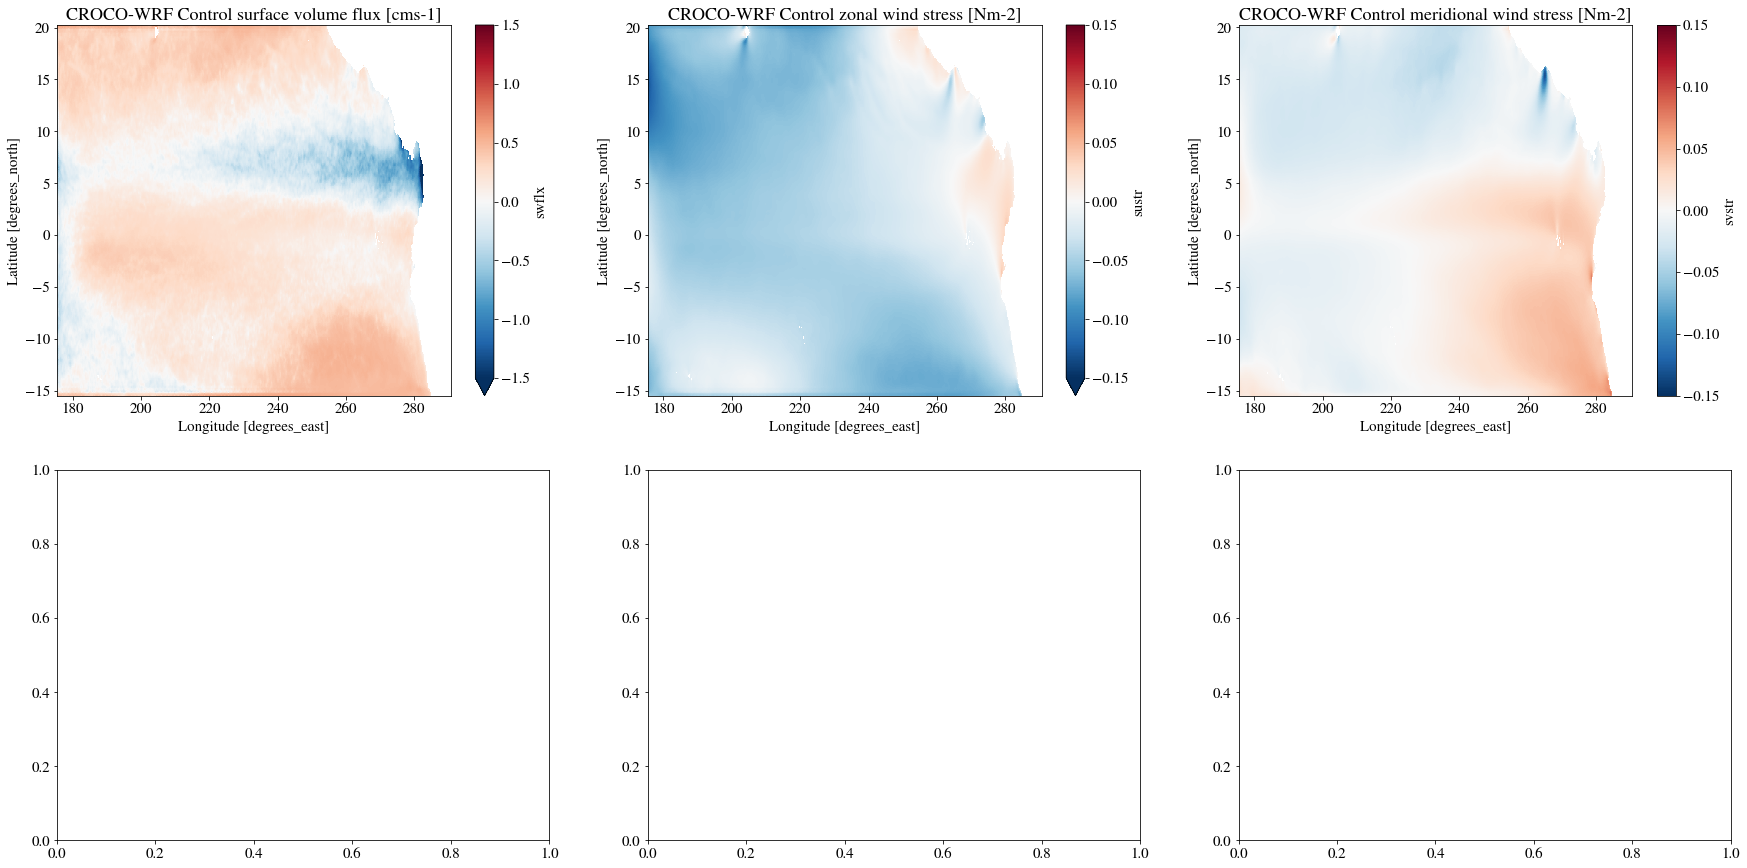

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(30,15),facecolor='w')

cont = 'CROCO-WRF Control'
pert = 'CROCO-WRF Smooth-SST'

SWFLX[cont].plot(ax=axes[0][0],vmin=-1.5,vmax=1.5,cmap='RdBu_r')
axes[0][0].set_title(cont + ' surface volume flux [cms-1]')
TAUU[cont].plot(ax=axes[0][1],vmin=-0.15,vmax=0.15,cmap='RdBu_r')
axes[0][1].set_title(cont + ' zonal wind stress [Nm-2]')
TAUV[cont].plot(ax=axes[0][2],vmin=-0.15,vmax=0.15,cmap='RdBu_r')
axes[0][2].set_title(cont + ' meridional wind stress [Nm-2]')
    
(SWFLX[pert]-SWFLX[cont]).plot(ax=axes[1][0],vmin=-0.3,vmax=0.3,cmap='RdBu_r')
axes[1][0].set_title(pert + ' surface volume flux [cms-1]')
(TAUU[pert]-TAUU[cont]).plot(ax=axes[1][1],vmin=-0.015,vmax=0.015,cmap='RdBu_r')
axes[1][1].set_title(pert + ' zonal wind stress [Nm-2]')
(TAUV[pert]-TAUV[cont]).plot(ax=axes[1][2],vmin=-0.015,vmax=0.015,cmap='RdBu_r')
axes[1][2].set_title(pert + ' meridional wind stress [Nm-2]')

plt.tight_layout()
plt.savefig('CROCO-WRF_Smooth_SST-E2_2015-2016_P-E_Tau_Differences.png',dpi=100)

# SST, SSH and V variance (longitude filtering):

In [38]:
# Get data:
SST = {}
SSH = {}
V = {}
U = {}
keys = ['CROCO-WRF Control','CROCO-WRF Smooth-SST']

for key in keys:
    SST[key] = data[key]['day'].temp_surf
    SSH[key] = data[key]['day'].zeta
    V[key] = data[key]['day'].v_surf
    U[key] = data[key]['day'].u_surf
DX = (data[keys[0]]['day'].x_rho[1]-data[keys[0]]['day'].x_rho[0]).values

ln_hp_filt = 12.0

In [39]:
# Limit data sets for speed:
lats = -2., 10.
lons = 180., 275.
times = '2016-07-01','2017-03-01'

for key in keys:
    SST[key] = SST[key].sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
    SSH[key] = SSH[key].sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
    V[key] = V[key].sel(time=slice(times[0],times[1])).sel(y_v=slice(lats[0],lats[1])).sel(x_v=slice(lons[0],lons[1]))
    U[key] = U[key].sel(time=slice(times[0],times[1])).sel(y_u=slice(lats[0],lats[1])).sel(x_u=slice(lons[0],lons[1]))

In [14]:
# Do high-pass filtering:
ln_hp_filt = 12.0
SST_hp_std = {}
for key in keys:
    print(key)
    SST_hp = (SST[key]-SST[key].rolling(x_rho=int(ln_hp_filt/DX),center=True).mean())
    SST_hp_std[key] = SST_hp.std('time')
    SST_hp_std[key].load()

CROCO-WRF Control


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CROCO-WRF Smooth-SST


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [15]:
SSH_hp_std = {}
for key in keys:
    print(key)
    SSH_hp = (SSH[key]-SSH[key].rolling(x_rho=int(ln_hp_filt/DX),center=True).mean())
    SSH_hp_std[key] = SSH_hp.std('time')
    SSH_hp_std[key].load()

CROCO-WRF Control


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CROCO-WRF Smooth-SST


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [16]:
V_hp_std = {}
for key in keys:
    print(key)
    V_hp = (V[key]-V[key].rolling(x_v=int(ln_hp_filt/DX),center=True).mean())
    V_hp_std[key] = V_hp.std('time')
    V_hp_std[key].load()

CROCO-WRF Control
CROCO-WRF Smooth-SST


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [40]:
U_hp_std = {}
for key in keys:
    print(key)
    U_hp = (U[key]-U[key].rolling(x_u=int(ln_hp_filt/DX),center=True).mean())
    U_hp_std[key] = U_hp.std('time')
    U_hp_std[key].load()

CROCO-WRF Control
CROCO-WRF Smooth-SST


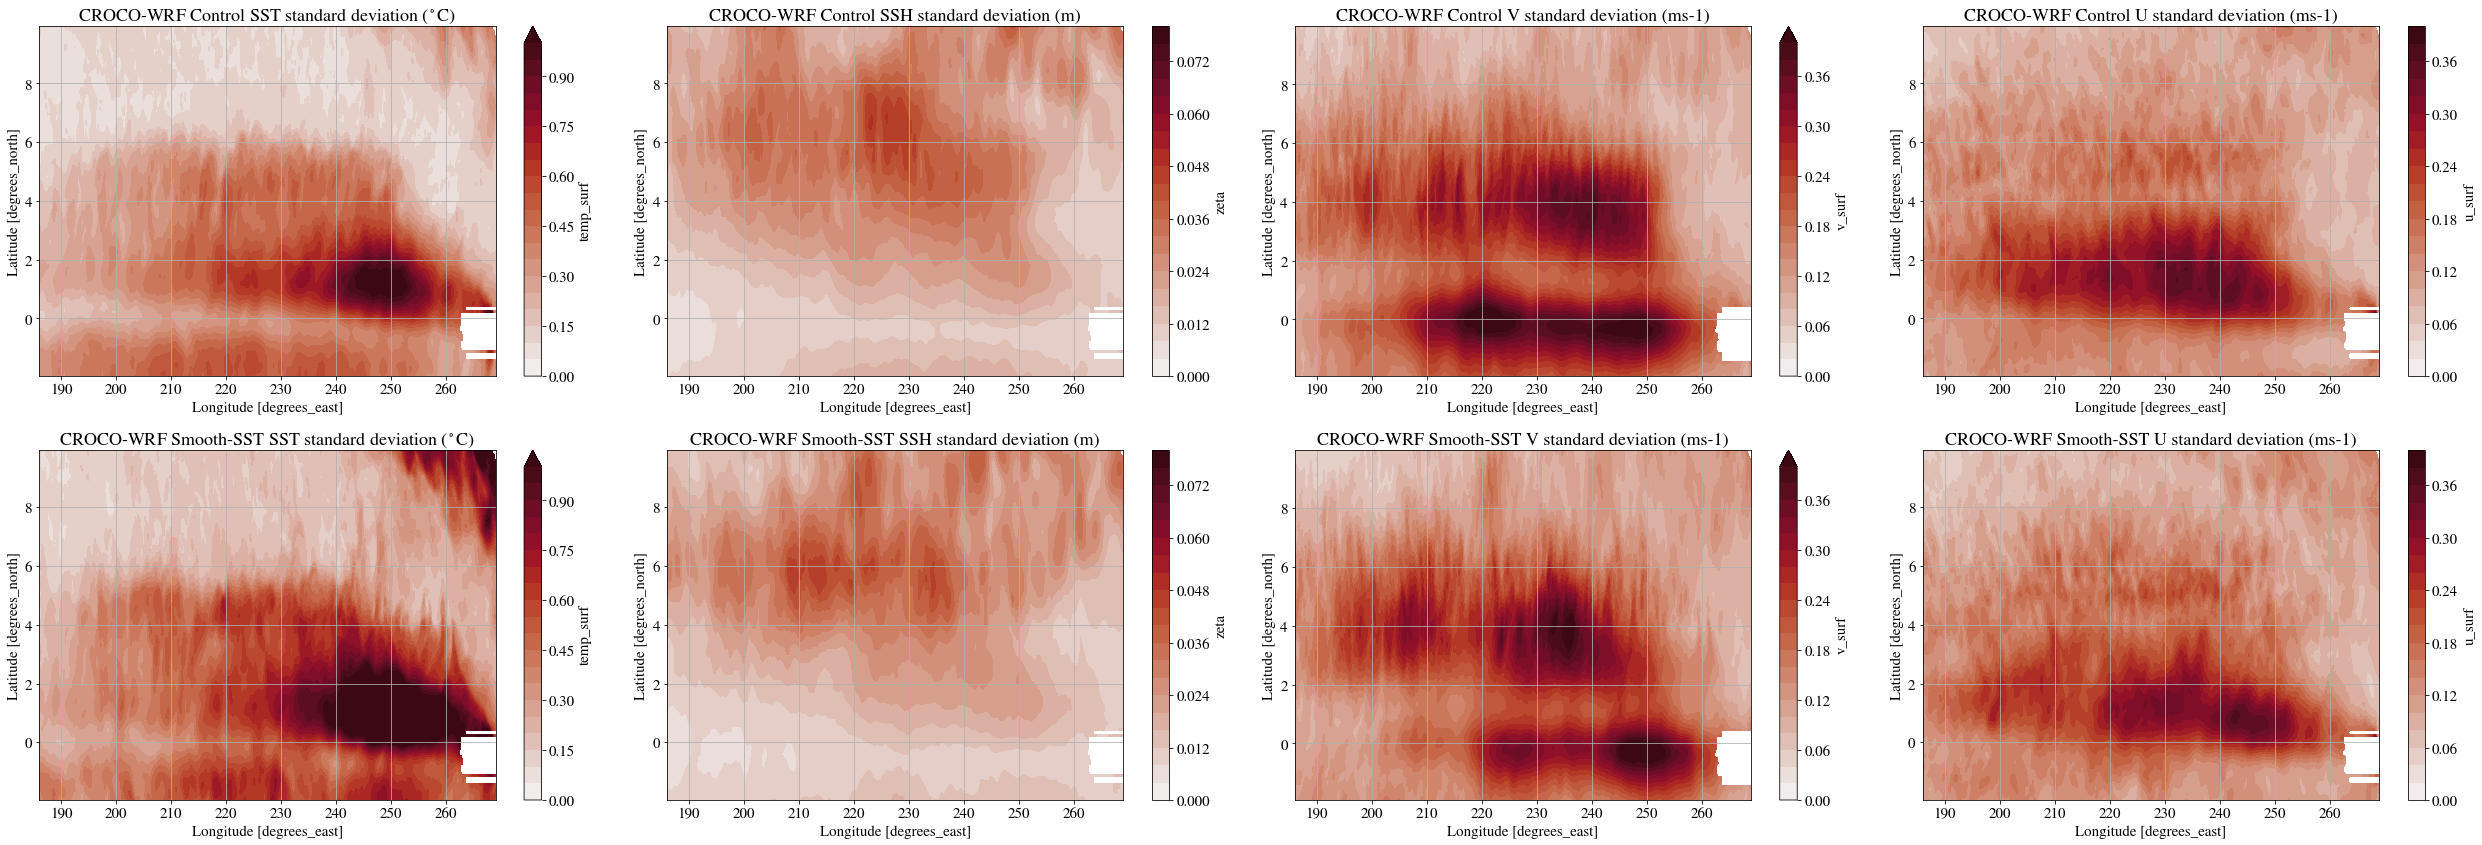

In [42]:
tlims = 0.,1.
zlims = 0.,0.08
vlims = 0.,0.4
tsp = tlims[1]/20.
zsp = zlims[1]/20.
vsp = vlims[1]/20.

# Do the plotting:
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(35,12),facecolor='w')
for i,key in enumerate(keys):
    SST_hp_std[key].plot.contourf(ax=axes[i][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
    SSH_hp_std[key].plot.contourf(ax=axes[i][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
    V_hp_std[key].plot.contourf(ax=axes[i][2],levels=np.arange(vlims[0],vlims[1]+vsp,vsp),cmap=cm.cm.amp)
    U_hp_std[key].plot.contourf(ax=axes[i][3],levels=np.arange(vlims[0],vlims[1]+vsp,vsp),cmap=cm.cm.amp)
    axes[i][0].set_title(key + ' SST standard deviation ($^\circ$C)')
    axes[i][1].set_title(key + ' SSH standard deviation (m)')
    axes[i][2].set_title(key + ' V standard deviation (ms-1)')
    axes[i][3].set_title(key + ' U standard deviation (ms-1)')

for ax in axes.reshape(-1):
    ax.set_xlim([lons[0]+ln_hp_filt/2.,lons[1]-ln_hp_filt/2.])
    ax.grid()
plt.tight_layout()
#plt.savefig('Validation_Figures/SSH_SST_V_HighPassLon_2016-07_2017-03_CROCO_CROCO-WRF_OBS.png',dpi=150)

Text(0.5, 0, '150W-90W U standard deviation (ms-1)')

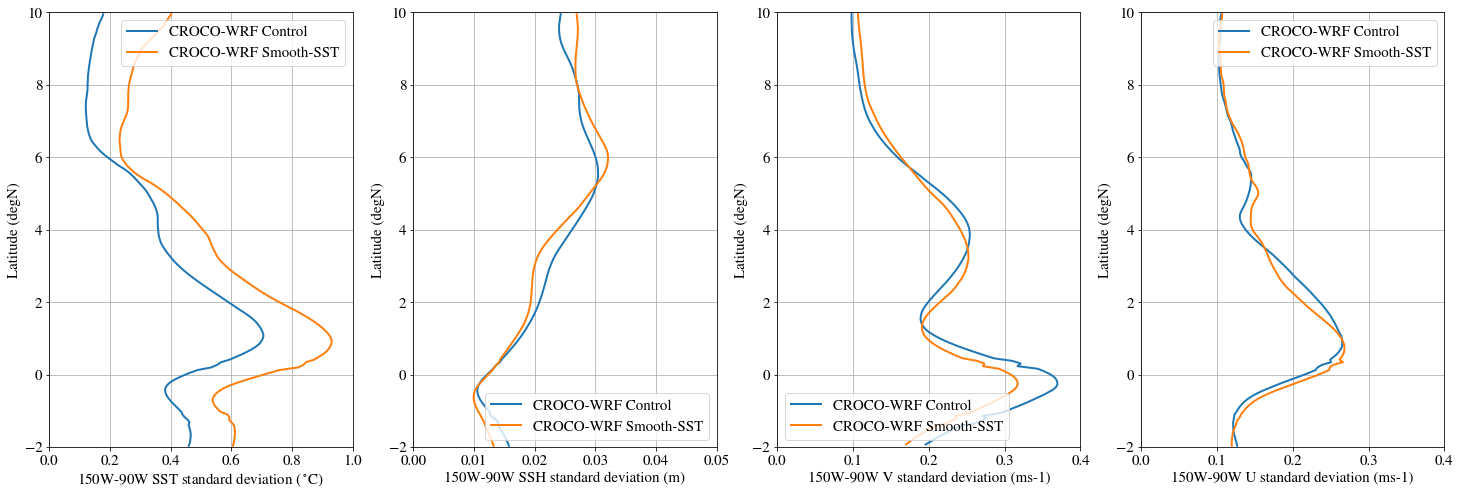

In [45]:
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(25,8))
reg = -150.,-90.

for key in keys:
    SST_hp_std[key].sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[0],label=key)
    SSH_hp_std[key].sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[1],label=key)
    V_hp_std[key].sel(x_v=slice(reg[0]+360.,reg[1]+360.)).mean('x_v').plot(ax=axes[2],label=key)
    U_hp_std[key].sel(x_u=slice(reg[0]+360.,reg[1]+360.)).mean('x_u').plot(ax=axes[3],label=key)

for ax in axes:
    for obj in ax.lines:   
        newx = obj.get_ydata()
        newy = obj.get_xdata()

# set new x- and y- data for the line
        obj.set_xdata(newx)
        obj.set_ydata(newy)

for axs in axes.reshape(-1):
    axs.set_ylim([-2.,10.])
    axs.legend()
    axs.grid()
    axs.set_ylabel('Latitude (degN)')
axes[0].set_xlim([0.,1.])
axes[1].set_xlim([0.,0.05])
axes[2].set_xlim([0.,0.4])
axes[3].set_xlim([0.,0.4])
axes[0].set_xlabel('150W-90W SST standard deviation ($^\circ$C)')
axes[1].set_xlabel('150W-90W SSH standard deviation (m)')
axes[2].set_xlabel('150W-90W V standard deviation (ms-1)')
axes[3].set_xlabel('150W-90W U standard deviation (ms-1)')

#plt.savefig('CROCO_WRF_SSH_SST_FiltPlot_LonAvg.png',dpi=300)

Text(0.5, 0, '150W-90W U standard deviation %-change')

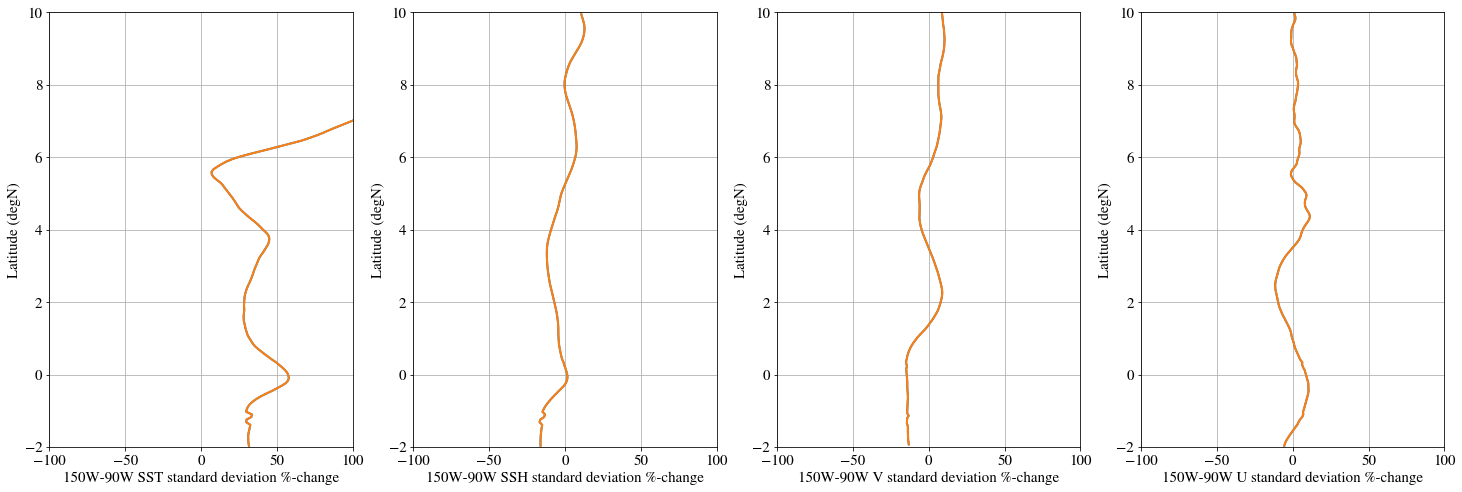

In [48]:
# Percentage change:
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(25,8))
reg = -150.,-90.

ControlSST = SST_hp_std['CROCO-WRF Control'].sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho')
ControlSSH = SSH_hp_std['CROCO-WRF Control'].sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho')
ControlV = V_hp_std['CROCO-WRF Control'].sel(x_v=slice(reg[0]+360.,reg[1]+360.)).mean('x_v')
ControlU = U_hp_std['CROCO-WRF Control'].sel(x_u=slice(reg[0]+360.,reg[1]+360.)).mean('x_u')

SmoothSST = SST_hp_std['CROCO-WRF Smooth-SST'].sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho')
SmoothSSH = SSH_hp_std['CROCO-WRF Smooth-SST'].sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho')
SmoothV = V_hp_std['CROCO-WRF Smooth-SST'].sel(x_v=slice(reg[0]+360.,reg[1]+360.)).mean('x_v')
SmoothU = U_hp_std['CROCO-WRF Smooth-SST'].sel(x_u=slice(reg[0]+360.,reg[1]+360.)).mean('x_u')

for key in keys:
    ((SmoothSST/ControlSST-1.)*100.).plot(ax=axes[0],label=key)
    ((SmoothSSH/ControlSSH-1.)*100.).plot(ax=axes[1],label=key)
    ((SmoothV/ControlV-1.)*100.).plot(ax=axes[2],label=key)
    ((SmoothU/ControlU-1.)*100.).plot(ax=axes[3],label=key)

for ax in axes:
    for obj in ax.lines:   
        newx = obj.get_ydata()
        newy = obj.get_xdata()

# set new x- and y- data for the line
        obj.set_xdata(newx)
        obj.set_ydata(newy)

for axs in axes.reshape(-1):
    axs.set_ylim([-2.,10.])
    axs.set_xlim([-100.,100.])
    axs.grid()
    axs.set_ylabel('Latitude (degN)')
axes[0].set_xlabel('150W-90W SST standard deviation %-change')
axes[1].set_xlabel('150W-90W SSH standard deviation %-change')
axes[2].set_xlabel('150W-90W V standard deviation %-change')
axes[3].set_xlabel('150W-90W U standard deviation %-change')

#plt.savefig('CROCO_WRF_SSH_SST_FiltPlot_LonAvg.png',dpi=300)

# Some snapshots and TIW filtering (WRF data):

In [ ]:
#Calculations:
time = '2016-11-01'

ln_hp_filt = 12.0
DX = (data['CROCO-WRF Control']['wrf_day'].nav_lon[0,1]-data['CROCO-WRF Control']['wrf_day'].nav_lon[0,0]).values

SST = (data['CROCO-WRF Control']['wrf_day'].SST-273.15).sel(time=time)
SST = SST.where(SST>-10.)
WSP = data['CROCO-WRF Control']['wrf_day'].WSPD10.sel(time=time)
LH = data['CROCO-WRF Control']['wrf_day'].LH.sel(time=time)

SST_TIW = (SST-SST.rolling(x=int(ln_hp_filt/DX),center=True).mean())
WSP_TIW = (WSP-WSP.rolling(x=int(ln_hp_filt/DX),center=True).mean())

In [ ]:
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(16,15))

SST.isel(time=0).plot.contour(levels=np.arange(0.,30.,0.5),colors='k',ax=axes[0])
SST_TIW.plot(ax=axes[0],vmin=-2.,vmax=2.,cmap='RdBu_r')
#WSP_TIW.isel(time=0).plot.contour(levels=np.arange(-3.0,0.,0.3),linestyle='dashed',colors='b',ax=axes)
#WSP_TIW.isel(time=0).plot.contour(levels=np.arange(0.3,3.3,0.3),colors='b',ax=axes)

WSP_TIW.plot(ax=axes[1],vmin=-1.5,vmax=1.5,cmap='RdBu_r')
SST_TIW.isel(time=0).plot.contour(levels=np.arange(-3.0,0.,0.5),linestyle='dashed',colors='k',ax=axes[1])
SST_TIW.isel(time=0).plot.contour(levels=np.arange(0.5,3.5,0.5),colors='k',ax=axes[1])

SST.isel(time=0).plot.contour(levels=np.arange(0.,30.,0.5),colors='k',ax=axes[2])
(-LH).plot(ax=axes[2],vmin=-200.,vmax=200.,cmap='RdBu_r')

for ax in axes:
    ax.set_xlim([180.,280.])
    ax.set_ylim([-6.,9.])
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
axes[0].set_title(time + ' SST and TIW SST anomalies (degC)')
axes[1].set_title(time + ' TIW 10m wind speed anomalies (ms-1) and SST anomaly contours (0.5degC)')
axes[2].set_title(time + ' Latent Heat Flux (Wm-2) and SST contours (0.5degC)')
plt.tight_layout()
plt.savefig('SST_WSP_LH.png',dpi=200)

# Analysis/comparison of 2016-2017 La Nina:

In [10]:
# Region definitions:

TIWyreg = [-5.,8.]
TIWxreg = [200.,260.]
N34yreg = [-5.,5.]
#N34xreg = [-170.+360.,-120.+360.]
#N34xreg = [-150.+360.,-90.+360.]
N34xreg = TIWxreg

0
1
2
3
4
5


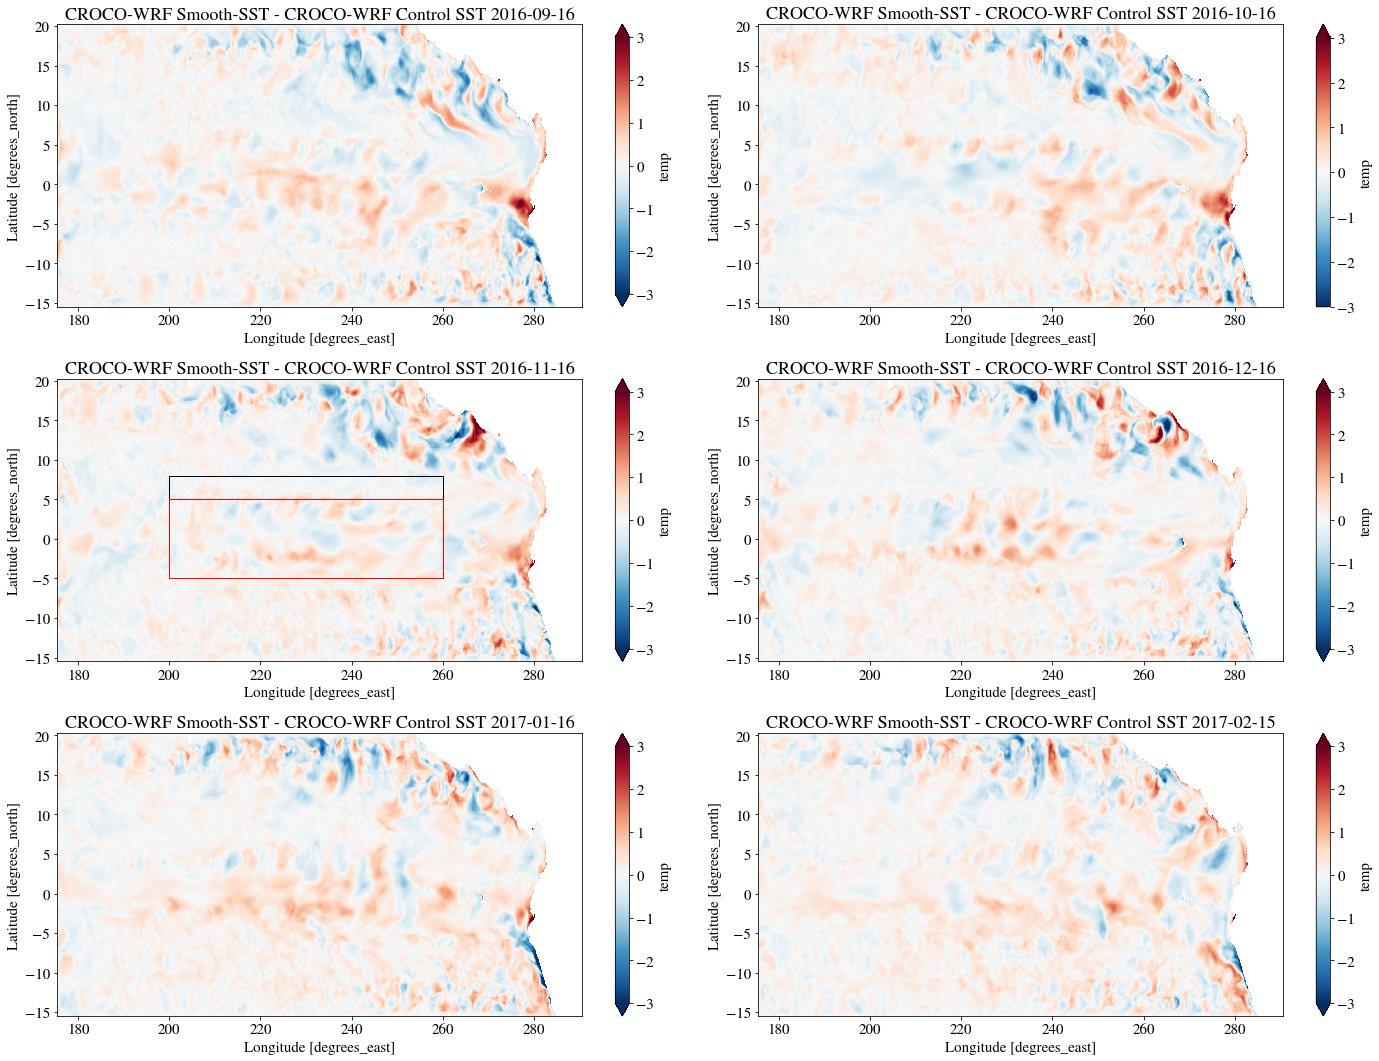

In [11]:
# Monthly SSTs:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15),facecolor='w')
axs = axes.reshape(-1)

SST_CONT = data['CROCO-WRF Control']['mon'].temp.isel(s_rho=-1)
SST_SMTH = data['CROCO-WRF Smooth-SST-E2']['mon'].temp.isel(s_rho=-1)

month_one = '2016-09-15'
cont_ind = list(SST_CONT.time.values).index(SST_CONT.sel(time=month_one, method='nearest').time)
smth_ind = list(SST_SMTH.time.values).index(SST_SMTH.sel(time=month_one, method='nearest').time)

for i in range(6):
    print(i)
    SST1 = SST_CONT.isel(time=i+cont_ind)
    SST2 = SST_SMTH.isel(time=i+smth_ind)
    (SST2-SST1).plot(ax=axs[i],vmin=-3.,vmax=3.,cmap='RdBu_r')
    axs[i].set_title('CROCO-WRF Smooth-SST - CROCO-WRF Control SST ' + str(SST1.time.values)[:10])
i = 2
axs[i].add_patch(Rectangle((TIWxreg[0], TIWyreg[0]), TIWxreg[1]-TIWxreg[0], TIWyreg[1]-TIWyreg[0],
             edgecolor = 'black',
             fill=False,
             lw=1))
    
axs[i].add_patch(Rectangle((N34xreg[0], N34yreg[0]), N34xreg[1]-N34xreg[0], N34yreg[1]-N34yreg[0],
             edgecolor = 'red',
             fill=False,
             lw=1))

plt.tight_layout()
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])
plt.savefig('Smooth-SST/LaNina_2016-2017_Monthly_SST_Difference-E2.png',dpi=100)

In [12]:
#Calculations:
ln_hp_filt = 12.0
keys = ['CROCO-WRF Control','CROCO-WRF Smooth-SST','CROCO-WRF Smooth-SST-E2']

SST = {}
SST_TIW = {}
V_TIW = {}
DX = (data['CROCO-WRF Control']['day'].x_rho[1]-data['CROCO-WRF Control']['day'].x_rho[0]).values

for key in keys:
    SST[key] = data[key]['day'].temp_surf
    SST[key] = SST[key].where(SST[key]>-10.)
    SST_TIW[key] = (SST[key]-SST[key].rolling(x_rho=int(ln_hp_filt/DX),center=True).mean())
    
    V = data[key]['day'].v_surf
    V_TIW[key] = (V-V.rolling(x_v=int(ln_hp_filt/DX),center=True).mean())

In [13]:
times = ['2016-09-01','2017-03-01']
for key in keys:
    print(key + ' SST')
    SST[key] = SST[key].sel(time=slice(times[0],times[1])).load()
    SST_TIW[key] = SST_TIW[key].sel(time=slice(times[0],times[1])).load()
    print(key + ' V')
    V_TIW[key] = V_TIW[key].sel(time=slice(times[0],times[1])).load()


CROCO-WRF Control SST
CROCO-WRF Control V
CROCO-WRF Smooth-SST SST
CROCO-WRF Smooth-SST V
CROCO-WRF Smooth-SST-E2 SST
CROCO-WRF Smooth-SST-E2 V


In [ ]:
time = '2016-11-01'
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(16,13),facecolor='w')

for i, key in enumerate(keys):
    SST_TIW[key].sel(time=time).plot(ax=axes[i][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
    axes[i][0].set_title('TIW-SST ' + key)
    
    V_TIW[key].sel(time=time).plot(ax=axes[i][1],vmin=-1.5,vmax=1.5,cmap='RdBu_r')
    axes[i][1].set_title('TIW-V ' + key)

    axes[i][1].add_patch(Rectangle((TIWxreg[0], TIWyreg[0]), TIWxreg[1]-TIWxreg[0], TIWyreg[1]-TIWyreg[0],
             edgecolor = 'black',
             fill=False,
             lw=1))
    
    axes[i][1].add_patch(Rectangle((N34xreg[0], N34yreg[0]), N34xreg[1]-N34xreg[0], N34yreg[1]-N34yreg[0],
             edgecolor = 'red',
             fill=False,
             lw=1))
    
plt.savefig('Smooth-SST/LaNina_2016-2017_TIW_V-SST.png',dpi=100)

In [14]:
yflx = 3.

SST_TIW_ts = {}
N34 = {}
V_TIW_ts = {}

VT_TIW_ts = {}
SHFLX_ts = {}

for key in keys:
    SST_TIW_ts[key] = (SST_TIW[key].sel(x_rho=slice(TIWxreg[0],TIWxreg[1])).sel(y_rho=slice(TIWyreg[0],TIWyreg[1]))**2.).mean('x_rho').mean('y_rho')
    V_TIW_ts[key] = (V_TIW[key].sel(x_v=slice(TIWxreg[0],TIWxreg[1])).sel(y_v=slice(TIWyreg[0],TIWyreg[1]))**2.).mean('x_v').mean('y_v')
    N34[key] = SST[key].sel(x_rho=slice(-170.+360.,-120.+360.)).sel(y_rho=slice(-5.,5.)).mean('x_rho').mean('y_rho')
    
    Tt = SST_TIW[key].sel(x_rho=slice(TIWxreg[0],TIWxreg[1])).sel(y_rho=yflx,method='nearest')
    Vt = V_TIW[key].sel(x_v=slice(TIWxreg[0],TIWxreg[1])).sel(y_v=yflx,method='nearest')
    VT_TIW_ts[key] = (Tt*Vt.rename({'x_v':'x_rho'})).mean('x_rho')
    
    print(key)
    SHFLX_ts[key] = data[key]['day'].shflx.sel(x_rho=slice(-170.+360.,-120.+360.)).sel(y_rho=slice(-5.,5.)).sel(time=slice(times[0],times[1])).mean('x_rho').mean('y_rho').load()

CROCO-WRF Control
CROCO-WRF Smooth-SST
CROCO-WRF Smooth-SST-E2


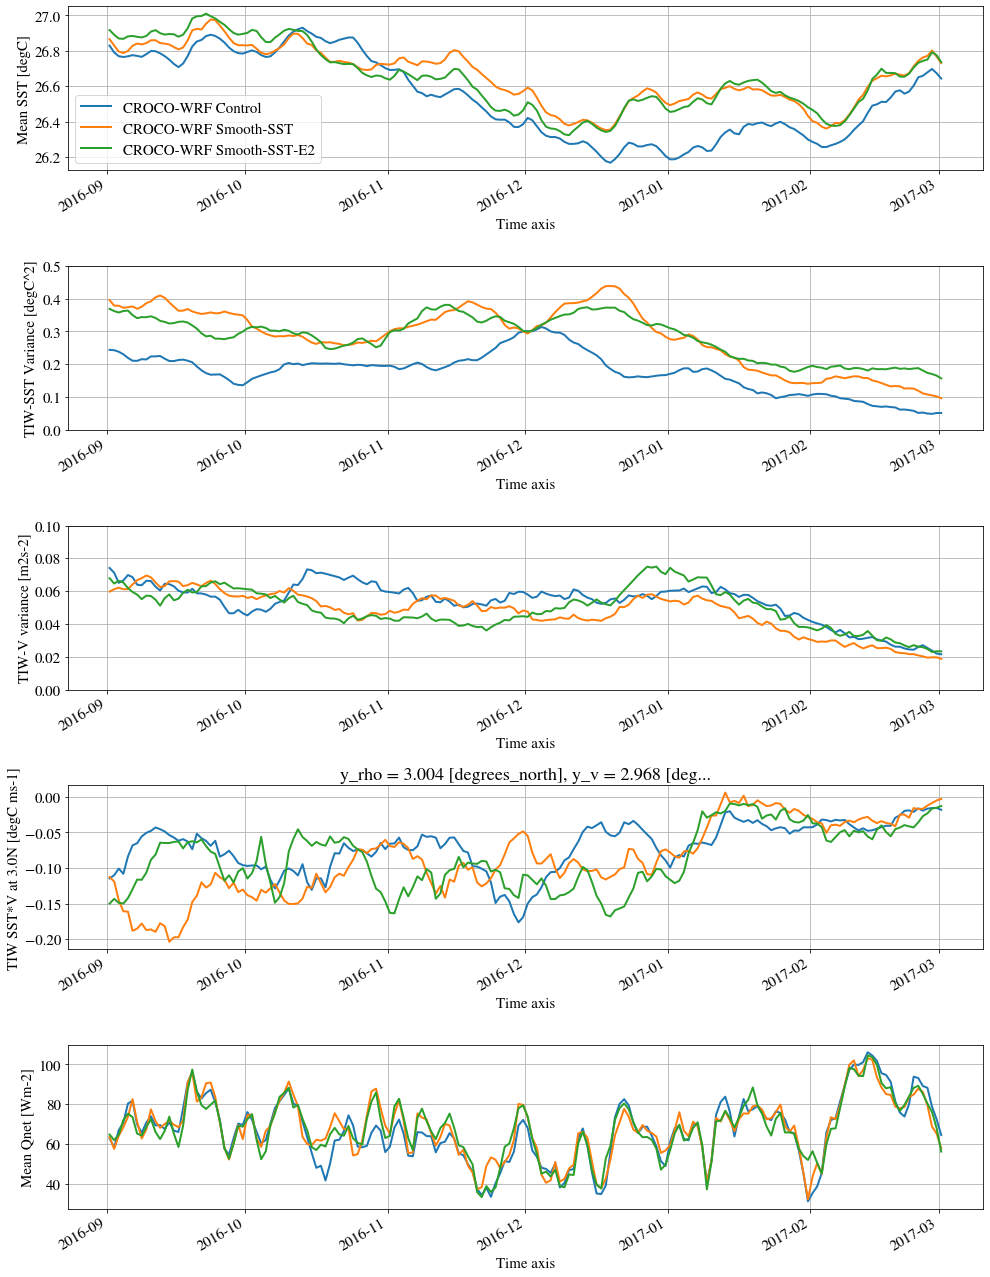

In [15]:
fig,axes = plt.subplots(nrows=5,ncols=1,figsize=(14,18),facecolor='w')
cols = ['C0','C1','C2']

for i, key in enumerate(keys):
    N34[key].plot(ax=axes[0],label=key,color=cols[i])
    SST_TIW_ts[key].plot(ax=axes[1],label=key,color=cols[i])
    V_TIW_ts[key].plot(ax=axes[2],label=key,color=cols[i])
    VT_TIW_ts[key].plot(ax=axes[3],label=key,color=cols[i])
    SHFLX_ts[key].plot(ax=axes[4],label=key,color=cols[i])
    
    # N34[key].resample(time="10D").mean().plot(ax=axes[0],color=cols[i],linestyle='dashed')
    # SST_TIW_ts[key].resample(time="10D").mean().plot(ax=axes[1],color=cols[i],linestyle='dashed')
    # V_TIW_ts[key].resample(time="10D").mean().plot(ax=axes[2],color=cols[i],linestyle='dashed')
    # VT_TIW_ts[key].resample(time="10D").mean().plot(ax=axes[3],color=cols[i],linestyle='dashed')
    # SHFLX_ts[key].resample(time="10D").mean().plot(ax=axes[4],color=cols[i],linestyle='dashed')
    
for axs in axes:
    axs.grid()
axes[0].legend()
axes[0].set_ylabel('Mean SST [degC]')
axes[1].set_ylabel('TIW-SST Variance [degC^2]')
axes[2].set_ylabel('TIW-V variance [m2s-2]')
axes[3].set_ylabel('TIW SST*V at ' + str(yflx) + 'N [degC ms-1]')
axes[4].set_ylabel('Mean Qnet [Wm-2]')
axes[2].set_ylim([0.,0.1])
axes[1].set_ylim([0.,0.5])
plt.tight_layout()

plt.savefig('Smooth-SST/LaNina_2016-2017_TimeSeries.png',dpi=100)

In [ ]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(15,10))

data['CROCO-WRF Control']['ts_3day'].T_Vmix.cumsum('s_rho').sel(time='2016-11-01',method='nearest').isel(s_rho=65).plot(ax=axes[0],vmin=-1.e-5,vmax=1.e-5)
data['CROCO-WRF Smooth-SST']['ts_3day'].T_Vmix.cumsum('s_rho').sel(time='2016-11-01',method='nearest').isel(s_rho=65).plot(ax=axes[1],vmin=-1.e-5,vmax=1.e-5)
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])

In [ ]:
fig,axes = plt.subplots(nrows=6,ncols=2,figsize=(30,30))
axs = axes.reshape(-1)

for i in range(12):
    print(i)
    SST1 = data['CROCO-WRF Control']['mon'].shflx.isel(time=i)
    SST2 = data['CROCO-WRF Smooth-SST']['mon'].shflx.isel(time=i)
    (SST2-SST1).plot(ax=axs[i],vmin=-50.,vmax=50.,cmap='RdBu_r')
    axs[i].set_title('CROCO-WRF Smooth-SST - CROCO-WRF Control Qnet 2016 Month ' + str(i+1))
plt.tight_layout()
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])

In [ ]:
time = '2016-11-15'
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(25,8))
axs = axes.reshape(-1)

TsqCONT = data['CROCO-WRF Control']['mon'].temp_sq.isel(s_rho=-1)-data['CROCO-WRF Control']['mon'].temp.isel(s_rho=-1)**2.
TsqSMTH = data['CROCO-WRF Smooth-SST']['mon'].temp_sq.isel(s_rho=-1)-data['CROCO-WRF Smooth-SST']['mon'].temp.isel(s_rho=-1)**2.

TsqCONT.isel(time=slice(8,11)).mean('time').plot(ax=axs[0],vmin=0.,vmax=2.,cmap=cm.cm.amp)
axs[0].set_title('CROCO-WRF Control submontly SST Variability Oct-Dec 2016 ($^\circ$C$^2$)')
TsqSMTH.isel(time=slice(8,11)).mean('time').plot(ax=axs[1],vmin=0.,vmax=2.,cmap=cm.cm.amp)
axs[1].set_title('CROCO-WRF Smooth-SST submontly SST Variability Oct-Dec 2016 ($^\circ$C$^2$)')
plt.tight_layout()
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])